# k-means with text data

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

The following code block will check if you have the correct version of GraphLab Create. Any version later than 1.8.5 will do. To upgrade, read [this page](https://turi.com/download/upgrade-graphlab-create.html).

In [1]:
import graphlab
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import re
from scipy.sparse import csr_matrix

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(graphlab.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476368187.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476368187.log


This non-commercial license of GraphLab Create for academic use is assigned to pvcastro@gmail.com and will expire on September 03, 2017.


## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [2]:
arquivos = graphlab.SFrame.read_json('arquivo.json')

Finished parsing file /media/discoD/Coursera/Data Science/arquivo.json

Parsing completed. Parsed 1 lines in 4.2849 secs.

In [3]:
def clean_text(text):
    list_of_cleaning_signs = ['\x0c', '\n']
    for sign in list_of_cleaning_signs:
        text = text.replace(sign, ' ')
    clean_text = re.sub('[^a-zA-Z]+', ' ', text)
    return clean_text.lower()

In [4]:
arquivos['clean'] = arquivos['api_Arquivo_bn'].apply(lambda x: clean_text(x))

In [5]:
arquivos['tf_idf'] = graphlab.text_analytics.tf_idf(arquivos['clean'])

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

In [6]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert x[column_name].dtype() == dict, \
        'The chosen column must be dict type, representing sparse data.'
        
    # Create triples of (row_id, feature_id, count).
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])
    # 1. Fit the transformer using the above data.
    f.fit(x)
    # 2. The transform takes 'feature' column and adds a new column 'feature_encoding'.
    x = f.transform(x)
    # 3. Get the feature mapping.
    mapping = f['feature_encoding']
    # 4. Get the feature id to use for each key.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    v = v.astype(float)
    v = np.nan_to_num(v)
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, mapping

In [7]:
# The conversion will take about a minute or two.
tf_idf, map_index_to_word = sframe_to_scipy(arquivos, 'tf_idf')

In [8]:
tf_idf

<129007x351506 sparse matrix of type '<type 'numpy.float64'>'
	with 12818955 stored elements in Compressed Sparse Row format>

The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [9]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [10]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [11]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[ 1.40002344  1.40618395]
 [ 1.40173367  1.41330177]
 [ 1.40336133  1.4117423 ]
 ..., 
 [ 1.40925627  1.40258973]
 [ 1.41027641  1.40957943]
 [ 1.40925224  1.40643167]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [12]:
# Students should write code here
first_three = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, first_three, metric='euclidean')
dist = distances[430, 1]
print dist

1.39343016098


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [13]:
# Students should write code here
print distances
closest_cluster = np.argmin(distances, 1)
print closest_cluster

[[ 0.          1.37705113  1.32579987]
 [ 1.37705113  0.          1.38727619]
 [ 1.32579987  1.38727619  0.        ]
 ..., 
 [ 1.3847262   1.40973206  1.37545166]
 [ 1.40008444  1.41195603  1.41148521]
 [ 1.40127991  1.41215295  1.40836539]]
[0 1 2 ..., 2 0 0]


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [14]:
# Students should write code here
first_three = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, first_three, metric='euclidean')
cluster_assignment = np.argmin(distances, 1)

Now we are ready to fill in the blanks in this function:

In [15]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, 1)
    
    return cluster_assignment

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [16]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [17]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [18]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [19]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    40379 elements changed their cluster assignment.
2
    10300 elements changed their cluster assignment.
3
     9884 elements changed their cluster assignment.
4
     4690 elements changed their cluster assignment.
5
      700 elements changed their cluster assignment.
6
      128 elements changed their cluster assignment.
7
       51 elements changed their cluster assignment.
8
       16 elements changed their cluster assignment.
9
        7 elements changed their cluster assignment.
10
        5 elements changed their cluster assignment.
11
        2 elements changed their cluster assignment.
12
        2 elements changed their cluster assignment.
13
        1 elements changed their cluster assignment.
14


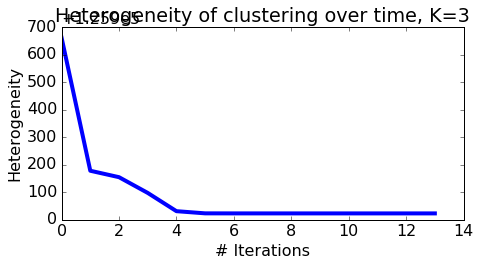

In [20]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [21]:
np.bincount(cluster_assignment)

array([ 8996, 86510, 33501])

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [22]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    print np.bincount(cluster_assignment)
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=125289.30028
[ 8590 17944 22665  8131  5394 53727  4560  1642  3282  3072]
seed=020000, heterogeneity=125379.39333
[48966 16744  3074  8624 21600  7482  3244  2671 11321  5281]
seed=040000, heterogeneity=125424.21339
[ 5169 16367  9805 16416  7655 10124 34357  7251 13370  8493]
seed=060000, heterogeneity=125316.70938
[ 3283  5162  8704  5181 10606 23327 47925  4250  3361 17208]
seed=080000, heterogeneity=125387.45481
[15835 36673  5621  5118  8531  3140 15179 18141  7140 13629]
seed=100000, heterogeneity=125329.50974
[ 4541  7702  3258  3202  5540 17719  8630 48278  4518 25619]
seed=120000, heterogeneity=125289.19867
[ 4565  3289 50336  5406 18222  3345  7159  2945 24999  8741]
129.996273041


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [23]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [24]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=125438.75342
seed=020000, heterogeneity=125380.58161
seed=040000, heterogeneity=125367.75603
seed=060000, heterogeneity=125326.08860
seed=080000, heterogeneity=125373.09888
seed=100000, heterogeneity=125388.04140
seed=120000, heterogeneity=125294.13766
228.857429028


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

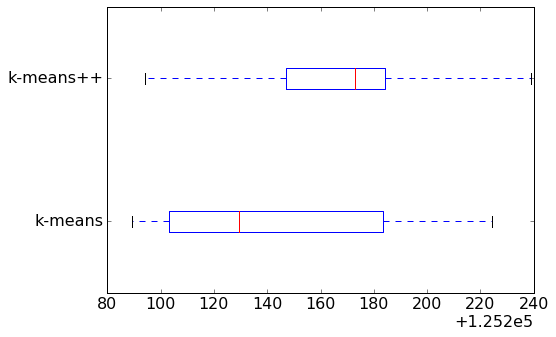

In [25]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about one hour to finish. We highly suggest that you use the arrays that we have computed for you.**

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

To use the pre-computed NumPy arrays, first download kmeans-arrays.npz as mentioned in the reading for this assignment and load them with the following code.  Make sure the downloaded file is in the same directory as this notebook.

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [26]:
def visualize_document_clusters(arquivos, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(arquivos[nearest_neighbors[i]]['clean'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(arquivos[nearest_neighbors[i]]['ctr_id'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

In [27]:
k = 4
seed = 120000
maxiter = 400
# Use k-means++ initialization
initial_centroids = smart_initialize(tf_idf, k, seed)
# Run k-means
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=maxiter,
                                   record_heterogeneity=None, verbose=True)
visualize_document_clusters(arquivos, tf_idf, centroids, cluster_assignment, k, map_index_to_word)

0
1
    47464 elements changed their cluster assignment.
2
    36525 elements changed their cluster assignment.
3
    14183 elements changed their cluster assignment.
4
     9567 elements changed their cluster assignment.
5
     2313 elements changed their cluster assignment.
6
      359 elements changed their cluster assignment.
7
       96 elements changed their cluster assignment.
8
       37 elements changed their cluster assignment.
9
       12 elements changed their cluster assignment.
10
        4 elements changed their cluster assignment.
11
        1 elements changed their cluster assignment.
12
        2 elements changed their cluster assignment.
13
Cluster 0     sp:0.149 ao:0.034 paulo:0.016 poetagem:0.014 jf:0.014 

* c7fac34db6e4f15a81aecfb491e0f82633b558f3           0.94899
  igia correios aten o ap s a a tentativa colocar o objeto em posta restante tentativas de e
  ntrega h h h motivo de devolu o

* 21d2a63c8188b43511edebd654c5d5b2a9323c32           0.95517
  ar ag ii i

In [28]:
np.bincount(cluster_assignment)

array([ 4718,  9003, 31957, 83329])

In [29]:
arquivos['clean']

dtype: str
Rows: 129007
[' concordia sc ii ii ii li ii ii ii ii agetop r j na p se ed ggran dr gt data de postagem controle r agetop tentativas de entrega corre h h h aten o ap s tr s tentativas de entrega emitir aviso de chegada e dolocir o objeto cru posta restante por sete dias motivos da devolu o mudou se recusado mendere o insuficiente el n o procurado n o existe o n mero ausente li desconhecido li falecido outros da i y o e tia placa mec sc auto a vencimento gr a destinat rio trans kothe transportes rodoviarios ltda rua joao suzin marini sala salete ar ag endere o para devolu o do ar centro de digitaliza o da dr carimbo unida e de entrega gonc fev c assinatura d recebeo v rxze g nome l rubrica e matricula do carteiro oto cow ct ll i t e cp e g c fe a c a gt c correio ntran uo', 'na itseeo ggran dr gt data de potagem p de oliveira transportes me r ver joao vitor costa sala a bro boa vista erizmiirim do agetop correio agetop tentativas de entrega siqueira campos pr for kis o di car